In [1]:
## aim to predict the escalation of users using RNN and compare with other baseline classfiers

In [8]:
import pandas as pd
import numpy 
import os
import git
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot
import numpy as np
import re
from collections import Counter
# import gensim
# from gensim import corpora
import os
import networkx as nx
import ast
import xgboost
from xgboost import XGBClassifier

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [42]:
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.layers import Average
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tqdm.auto import tqdm

In [12]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [13]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [14]:
# setup env
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
## tokenize the text..
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer as keras_Tokenizer
from sklearn.metrics import classification_report
from keras.layers import Embedding
from nltk.tokenize import TweetTokenizer
tweet_tknzr = TweetTokenizer()
def get_tokens(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tokens = tweet_tknzr.tokenize(sentence)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if (token not in stopwords and len(token) > 1)] ## remove punctuations
    tokens = [get_lemma(token) for token in tokens]
    return (tokens)

In [16]:
def clean_text(text):
    text = re.sub(r'(https?://\S+)', "", text) ## remove url
    text = re.sub(r'(\@\w+)', "author",text)   ## remove @ mentions with author
    text = re.sub(r'(@)', "",text)             ## remove @ symbols
    text = re.sub(r'(author)',"",text)         ## remove author
    text = re.sub(r'(#)', "",text)             ## removing the hashtags signal 
    text = re.sub(r'(RT )', "",text)         ## remove the retweet info as they dont convey any information
    text = re.sub(r'(^:)',"",text)
    text.rstrip 
    text.lstrip
    return(text)

In [17]:
# create the word2vec dict from the dictionary
def get_word2vec(file_path):
    file = open(file_path, "r")
    if (file):
        word2vec = dict()
#         split = file.read().splitlines()
        for line in file:
            split_line = line.split(' ')
            key = split_line[0] # the first word is the key
            value = np.array([float(val) for val in split_line[1:]])
            word2vec[key] = value
        return (word2vec)
    else:
        print("invalid fiel path")

In [18]:
## get the embedding matrix weights:
from numpy import zeros
def get_embedding_matrix(keras_tkzr,word2vec):
    vocab_size = len(keras_tkzr.word_index) + 1
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in keras_tkzr.word_index.items():
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return (embedding_matrix,vocab_size)

In [19]:
## pass to the bi-lstm model
def create_model(max_len,vocab_size,embedding_matrix):
    input = Input(shape=(max_len,))
    model = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len)(input)
    model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
    model = TimeDistributed(Dense(100,activation='relu'))(model)
    model = Flatten()(model)
    model = Dense(100,activation='relu')(model)
    output = Dense(3,activation='softmax')(model)
    model = Model(input,output)
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model

In [20]:
## get the trained model
def train_evaluate_model(model,X_train,Y_train,X_test,Y_test):
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
    print('Accuracy: %f' % (accuracy*100))
    Y_pred = model.predict(X_test)
    y_pred = np.array([np.argmax(pred) for pred in Y_pred])
    # scores = cross_val_score(model, X_test, Y_test, cv=5)
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    precision,recall,fscore,_ = precision_recall_fscore_support(Y_test,y_pred)
    return (model,precision,recall,fscore)

In [21]:
top_dir = os.path.join(get_git_root(os.getcwd()))
input_dir = os.path.join(get_git_root(os.getcwd()),"input")
embeddings_dir  = os.path.join(get_git_root(os.getcwd()),"input","embeddings")
annotatted_dir = os.path.join(input_dir,"annotated_data")
classifier_dir = os.path.join(get_git_root(os.getcwd()),"models","classifier")
model_dir = os.path.join(get_git_root(os.getcwd()),"models")
poly_dir = os.path.join(model_dir,"poly_users")

In [22]:
# so wil filter the users that does have weed tweet before 2016
# it return the mono user in that year
def get_mono(first_data,year):
    first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
    first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])
    juul_users = list(first_data["userID"].loc[first_data["juul_first"].dt.year < year])
    print("juul_initial",len(juul_users))
    weed_users = list(first_data["userID"].loc[(first_data["weed_first"].dt.year < (year))])
    mono_users = list(set(juul_users) - set(weed_users))
    print("mono final",len(mono_users))
    return mono_users

In [23]:
## return the label of the poly users
def get_label_mono(tweets_data,first_data):  ## will change for year
    users = tweets_data.userID.unique()
    print("initial_users",len(users))
    poly_labelled =  list(first_data["userID"].loc[first_data.userID.isin(users) & (first_data.weed_first.isnull())]) ## all not null will become poly
    mono_labelled = (list(set(users) - set(poly_labelled)))   ## users that will change to poly in future year
    print("poly_users that will change",len(poly_labelled))
    print("users reaminin mono",len(mono_labelled))
    tweets_data["label"] = 0   ## initialize
    tweets_data.loc[tweets_data.userID.isin(poly_labelled),"label"] = 1  # all of the poly
    return(tweets_data)

In [24]:
def get_f1(Y_true,Y_pred):
    f_scores = precision_recall_fscore_support(Y_true,Y_pred)[2]
    supports = precision_recall_fscore_support(Y_true,Y_pred)[3]
    f1_num = 0
    for f_s,sup in zip(f_scores,supports):
        f1_num += (f_s * sup)
    f1 = f1_num / np.sum(supports)
    return(f1)

In [25]:
## join al the of the tweets for each user
def get_tweets_user(df):
    tqdm.pandas()
    df = df.groupby(['userID'])['tweetText'].progress_apply(lambda x: ','.join(x)).reset_index()
    return (df)

In [59]:
def get_lstm_model(max_len,vocab_size,dimension,embedding_matrix):
    max_len= max_len
    n_words = vocab_size
    print("creating model")
    input = Input(shape=(max_len,))
    model = Embedding(n_words,dimension,weights=[embedding_matrix],input_length=max_len)(input)
    model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
    model = Flatten()(model)
    model = Dense(100,activation='relu')(model)
    output = Dense(2,activation='sigmoid')(model)
    model = Model(input,output)
    # sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    print("compiling the model")
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [27]:
## returns the emnbedding matrix for the lstm model
def get_embedding_matrix(vocab_size,dimension,embedding_file,keras_tkzr):
    word2vec = get_word2vec(embedding_file)
    from numpy import zeros
    embedding_matrix = zeros((vocab_size, dimension))
    for word, i in keras_tkzr.word_index.items():
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [28]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
mono_users = pickle.load(open(os.path.join(poly_dir,"mono_users.pkl"),"rb"))

In [26]:
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")

In [56]:
## we taking data from juul and weed and not use the pattern
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
# ## filter the juul data to capture just the regualr users
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## we keep only the regular usrs
first_data = first_data.loc[first_data.userID.isin(regular_users)]

## we look at weed first and juul first tweets
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [57]:
## so will train the classfier on the bucket data

In [58]:
## bucket the users in bucket :
#1 2015 - [2015-2018] 
#2 2015- 2016 - [17 - 18]
#3 2015 - 2017 - [18]

## Sequential prediction using LSTM and baseline classfier for 2018 data

In [97]:
## so we are taking the users that start on Jan 2018 and change in the month of september, 
# and we change the threshold of input data to see how accurately we can predict that

In [34]:
## input data :juul_data 
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## look at the weed first and juul_first tweet
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first_data = first_data.loc[first_data.userID.isin(regular_users)]  # reg users
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [35]:
## removing the rewteet text column completely
ids_ = juul_data.loc[juul_data['retweetText'].notnull()]["tweetId"]
juul_data.loc[juul_data.tweetId.isin(ids_),"tweetText"] = juul_data.loc[juul_data.tweetId.isin(ids_)]["retweetText"]
juul_data = juul_data.drop(["hashtags","retweetText"],axis=1)
len(juul_data) ## 1353987 (sanity check)

1353987

In [36]:
len(juul_data) ## 1353987
len(juul_data.userID.unique()) ## 673724  reg users

673724

In [37]:
pd.isnull(list(first_data.loc[first_data.userID == 2534]["weed_first"])[0])

True

In [38]:
## get the users who start at jan 2018 
users_2018 = list(first_data["userID"][ 
    (first_data.juul_first.dt.year == 2018)
    & (first_data.juul_first.dt.month== 1)   ## selecting 2018, Jan data
    & (((first_data.weed_first.dt.date) > (first_data.juul_first.dt.date)) | (pd.isnull(first_data.weed_first)))
    & ((first_data.weed_first.dt.month >= 9) | (pd.isnull(first_data.weed_first)))]) # users who will change after september

poly_lbl = list(first_data["userID"].loc[(first_data.juul_first.dt.year == 2018)  
                                        & (first_data.juul_first.dt.month== 1) 
                                        & ((first_data.weed_first.dt.date) > (first_data.juul_first.dt.date))
                                        & ((first_data.weed_first.dt.month >= 9))
                                        ])
                                            ## users that will change
print("total users", len(users_2018))
print("users will change",len(poly_lbl))

total users 10760
users will change 929


In [39]:
data_2018 = juul_data.loc[juul_data.userID.isin(users_2018) & (juul_data.tweetCreatedAt.dt.year == 2018)]
print("total data", len(data_2018))
print("users",len(data_2018.userID.unique()))

## sanity check -- all users start in 2018 year..
data_2018 = juul_data.loc[juul_data.userID.isin(users_2018)]
print("total data", len(data_2018))
print("users",len(data_2018.userID.unique()))

total data 24018
users 10760
total data 24018
users 10760


In [40]:
## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_2018.userID.unique()
users_labelled = pd.DataFrame(users_,columns=["userID"])
users_labelled["label"] = 0  ## initialize
users_labelled.loc[users_labelled.userID.isin(poly_lbl) , "label"] = 1
len(users_labelled.loc[users_labelled.label == 1])  ## sanity check

929

In [41]:
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")


### functions for sequence LSTM

In [68]:
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")

In [69]:
def get_length(s):
    a = list(s.split())
    return(len(a))

In [70]:
## get window size
def get_window_size(df):
    tweet_count = df.groupby(by="userID")["tweetId"].count()
    tweet_count = tweet_count.reset_index()
    window = int(tweet_count.tweetId.quantile(0.95))
    return window

In [71]:
def get_max_length(df):
    ## max_length
    lengths = df["tweetText"].progress_apply(get_length)
    max_len = int(lengths.quantile(0.95))
    return (max_len)

In [72]:
def get_sequence(df,column,window,max_len):
    users = df.userID.unique()  # select the unique users
    X = []
    for user in tqdm(users):
        temp = list(df[column].loc[df.userID.isin([user])])
        if len(temp) < window:
            pad = np.zeros(((window-len(temp)),max_len))  # pad in case data is less than the window
            data = np.vstack((temp,pad))
        else:
            data = temp[:window]             ## truncate to be equal to window size
        X.append(data)
    return np.array(X)

In [73]:
def plot_coeff(k,model,feature_names):
    coef = (model.coef_.ravel()) 
    top_positive_coefficients = np.argsort(coef)[-k:]
    top_negative_coefficients = np.argsort(coef)[:k]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(17, 8))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * k), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * k), feature_names[top_coefficients], rotation=60, ha='right',fontsize= 20)
    plt.show()
    return coef

In [74]:
def get_lstm_tweet_seq(max_len,window,vocab_size,embedding_matrix):
    max_len= max_len
    n_words = vocab_size
    Dimension = 100
    input = Input(shape=(window,max_len,))
    model = Embedding(n_words,Dimension,weights=[embedding_matrix],input_length=(window,max_len,))(input)
    model = Reshape(target_shape=(window,(max_len*Dimension)))(model)
    # model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.25),merge_mode='concat')(model)
    model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.25),merge_mode='concat')(model)
    model = Flatten()(model)
    output = Dense(2,activation='sigmoid')(model)
    model = Model(input,output)
    # sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    print("compiling the model")
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [75]:
from keras.callbacks import Callback
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_predict = np.array([np.argmax(value) for value in val_predict])
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print ("— val_f1: %f — val_precision: %f — val_recall %f"%(_val_f1, _val_precision, _val_recall))
        print('  Classification Report:\n',classification_report(val_targ,val_predict),'\n')
        return

metrics = Metrics()

In [76]:
def training_plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [77]:
## return claean dataframe with sequneced X,y ; and embeddign matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
def prepare_data_rnn(df,users_labelled):
    dimension = 100
    
    df = df[["userID","tweetText","tweetId"]]
    ## data
    print("length of the data",len(df))
    
    print("users",len(df.userID.unique()))
    
    ## cleaning 
    print("cleanining the data")
    tqdm.pandas()
    df["tweetText"] = df["tweetText"].progress_apply(clean_text)
    df["tweetText"] = df["tweetText"].progress_apply(get_tokens).str.join(" ")
    
    ## print winodow , max_len for analysis purpose
    max_len = get_max_length(df)
    print("max_length",max_len)
    window= get_window_size(df)
    print("window_size",window)

    ## prepare the tokenizer
    print("preparing the tokenizer")
    keras_tkzr = keras_Tokenizer()
    keras_tkzr.fit_on_texts(df["tweetText"])
    vocab_size = len(keras_tkzr.word_index) + 1
    print("vocalb",vocab_size)
    
    ## embedding matrix
    print("creating glove embeddign matrix")
    embedding_matrix = get_embedding_matrix(vocab_size,dimension,embedding_file,keras_tkzr) ## tokenizer contains the vocalb info

    ## encoding the docs
    print("encoding the data")
    encoded_docs = keras_tkzr.texts_to_sequences(df["tweetText"])
    df["encoded_docs"] = list(pad_sequences(encoded_docs, maxlen=max_len, padding='post'))
    
    ## undersampling based on the users_labelled file
    users = np.array(list(users_labelled["userID"])).reshape(-1,1)
    label = list(users_labelled["label"])
    
    print("total users before",len(users))
    pos_samples = [ele for ele in label if ele==1]
    print("length of positive samples before",len(pos_samples))
    rus = RandomUnderSampler(random_state=0)
    rus.fit(users,label)
    users_sample, label_samples = rus.fit_sample(users,label)
    users_sample = list(users_sample)  ## changing the shape
    
    ## pos samples after
    pos_samples = [ele for ele in label_samples if ele==1]
    print("length of positive samples after",len(pos_samples))
    print("total users after",len(users_sample))
    
    # adjusting the dataframe based on random undersampling
    print("before data",len(df))
    print("users before",len(df.userID.unique()))
    df = df.loc[df.userID.isin(users_sample)]   ## under sampled data
    print("after data",len(df))
    print("after users",len(df.userID.unique()))
    
    ## getting output label 
    print("getting the output label")
    temp = df.groupby(by="userID")["tweetId"].count().reset_index()
    ## join with the users_labelled data to preserve the order
    temp = temp.join(users_labelled.set_index("userID"),on="userID",how="inner")
    y = list(temp["label"])
    
    ## get sequnced data (X)
    print("sequencing data")
    X = get_sequence(df,"encoded_docs",window,max_len)
    
    ## return sequenced data for reference
    agg_data = df.groupby(by="userID")["tweetText"].agg(';'.join).reset_index()
    agg_data = agg_data.join(users_labelled.set_index("userID"),on="userID",how="inner").reset_index(drop=True)
    return (agg_data,X,y,embedding_matrix,window,max_len,vocab_size)

In [78]:
# return trained model and F1 score 
def run_sequence_model(X,y,embedding_matrix,window,max_len,vocab_size,epoch,metrics,weights=None):
    dimension = 100
    ## split the data
    print("train-test split")
    X_train,X_test,Y_train,Y_test  = train_test_split(X, np.array(y),test_size =0.20,random_state= 4,shuffle=True ,
                                                      stratify= np.array(y))
    
    X_train,X_val,Y_train,Y_val  = train_test_split(X_train, Y_train,test_size =0.25,random_state= 4,shuffle=True ,
                                                     stratify= Y_train)
                                 
    print("X-train",X_train.shape)
    print("X-test",X_test.shape)
    
    
    print("creating lstm model")
    model = get_lstm_tweet_seq(max_len,window,vocab_size,embedding_matrix)
    
    print("adjusting the weights for each class")
    print(weights)
    print("training the model with balance dataset")
    
    history = model.fit(X_train,Y_train,validation_data = (X_val,Y_val) , nb_epoch = epoch, 
                        verbose = 1,batch_size=32,class_weight= weights,callbacks=[metrics])

    ##plotting trainin validation - no point as we dont want ot look at accuarcy
    training_plot(history)
    
    print("generating classfication report")
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
    print('Accuracy: %f' % (accuracy*100))
    ## lstm model
    temp = model.predict(X_test)
    y_pred = [np.argmax(value) for value in temp] 
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    f1_score = (get_f1(Y_test,y_pred))
    
    print("job finished")
    return (model,f1_score)

In [88]:
def prepare_data_lstm(df,users_labelled):
    dimension = 100
    
    df = df[["userID","tweetText","tweetId"]]
    ## data
    print("length of the data",len(df))
    
    print("users",len(df.userID.unique()))
    
    ## cleaning 
    print("cleanining the data")
    tqdm.pandas()
    df["tweetText"] = df["tweetText"].progress_apply(clean_text)
    df["tweetText"] = df["tweetText"].progress_apply(get_tokens).str.join(" ")
    
    ## print winodow , max_len for analysis purpose
    max_len = get_max_length(df)
    print("max_length",max_len)

    ## undersampling based on the users_labelled file
    users = np.array(list(users_labelled["userID"])).reshape(-1,1)
    label = list(users_labelled["label"])
    
    print("total users before",len(users))
    pos_samples = [ele for ele in label if ele==1]
    print("length of positive samples before",len(pos_samples))
    rus = RandomUnderSampler(random_state=0)
    rus.fit(users,label)
    users_sample, label_samples = rus.fit_sample(users,label)
    users_sample = list(users_sample)  ## changing the shape
    
    ## pos samples after
    pos_samples = [ele for ele in label_samples if ele==1]
    print("length of positive samples after",len(pos_samples))
    print("total users after",len(users_sample))
    
    # adjusting the dataframe based on random undersampling
    print("before data",len(df))
    print("users before",len(df.userID.unique()))
    df = df.loc[df.userID.isin(users_sample)]   ## under sampled data
    print("after data",len(df))
    print("after users",len(df.userID.unique()))
    
    data = df.groupby(by="userID")["tweetText"].apply(lambda x: "%s" % ' '.join(x)).reset_index()
    data = data.join(users_labelled.set_index("userID"),on="userID",how="inner")
    
    ## prepare the tokenizer
    print("preparing the tokenizer")
    keras_tkzr = keras_Tokenizer()
    keras_tkzr.fit_on_texts(data["tweetText"])
    vocab_size = len(keras_tkzr.word_index) + 1
    print("vocalb",vocab_size)
    
    ## embedding matrix
    print("creating glove embeddign matrix")
    embedding_matrix = get_embedding_matrix(vocab_size,dimension,embedding_file,keras_tkzr) ## tokenizer contains the vocalb info

    ## encoding the docs
    print("encoding the data")
    encoded_docs = keras_tkzr.texts_to_sequences(data["tweetText"])
    X = (pad_sequences(encoded_docs, maxlen=max_len, padding='post'))
    
    y = np.array(list(data["label"]))
    
    print("X",X.shape)
    print("y",y.shape)
    
    return (data,X,y,embedding_matrix,max_len,vocab_size)

In [84]:
def run_lstm_model(X,y,embedding_matrix,max_len,vocab_size,dimension,epoch,metrics,weights=None):
    ## split the data
    print("train-test split")
    X_train,X_test,Y_train,Y_test  = train_test_split(X, y,test_size =0.20,random_state= 4,shuffle=True ,
                                                      y)
    
    X_train,X_val,Y_train,Y_val  = train_test_split(X_train, Y_train,test_size =0.25,random_state= 4,shuffle=True ,
                                                     stratify= Y_train)
                                 
    print("X-train",X_train.shape)
    print("X-test",X_test.shape)
    
    
    print("creating lstm model")
    model = get_lstm_model(max_len,vocab_size,dimension,embedding_matrix)
    
    print("training the model with balance dataset")
    
    history = model.fit(X_train,Y_train,validation_data = (X_val,Y_val) , nb_epoch = epoch, 
                        verbose = 1,batch_size=32,class_weight= weights,callbacks=[metrics])

    ##plotting trainin validation - no point as we dont want ot look at accuarcy
    training_plot(history)
    
    print("generating classfication report")
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
    print('Accuracy: %f' % (accuracy*100))
    ## lstm model
    temp = model.predict(X_test)
    y_pred = [np.argmax(value) for value in temp] 
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    f1_score = (get_f1(Y_test,y_pred))
    
    print("job finished")
    return (model,f1_score)

In [81]:
def run_baslines(df,users_labelled):
    tqdm.pandas()
    df["tweetText"] = df["tweetText"].progress_apply(clean_text)
    df["tweetText"] = df["tweetText"].progress_apply(get_tokens).str.join(" ")
    data = df.groupby(by="userID")["tweetText"].apply(lambda x: "%s" % ' '.join(x)).reset_index()
    data = data.join(users_labelled.set_index("userID"),on="userID",how="inner")
    # ## prepare the tokenizer
    print("preparing the tokenizer")
    tf_idf = TfidfVectorizer(sublinear_tf=True)
    tf_idf.fit(data["tweetText"])
    X = tf_idf.fit_transform(data["tweetText"])
    y = np.array(list(data["label"]))
    
    print("downsampling")
    rus = RandomUnderSampler(random_state=0)
    rus.fit(X,y)
    X_sam, y_sam = rus.fit_sample(X,y)
    
    print("downsampled data length",(X_sam.shape))
    print("train-test split")
    
    X_train,X_test,Y_train,Y_test  = train_test_split(X_sam, y_sam,test_size =0.20,random_state= 4,shuffle=True ,
                                                          stratify= y_sam)
    print("training the models")
    print("svm")
    svm = LinearSVC(C=1,verbose=1)
    svm.fit(X_train,Y_train)
    
    print("rf")
    rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
    rf.fit(X_train,Y_train)
    
    print("xgBoost")
    xgb = XGBClassifier()
    xgb.fit(X_train, Y_train)
    
    print("predicting scores")
    print("svm")
    y_pred = svm.predict(X_test)
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    svm_score = (get_f1(Y_test,y_pred))
    
    print("random_forest")
    y_pred = rf.predict(X_test)
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    rf_score = (get_f1(Y_test,y_pred))
    
    print("xgboost")  
    y_pred = xgb.predict(X_test)
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    xgb_score = (get_f1(Y_test,y_pred))
    
    
    y_pred = [1 for x in range(len(Y_test))]
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    maj_score = (get_f1(Y_test,y_pred))
 

    print("job finished")
    final = {
        'svm': [svm,svm_score],
        'rf' : [rf,rf_score],
        'xg_boost': [xgb,xgb_score],
        'maj': [maj_score],
        'tf-idf': tf_idf,
    }
    return (final)

In [52]:
## sequence of tweets for user
## output prediction would be for the users so teh lstm layer would need to flatten to a single user..

## poly_turned : if users tweets weed after september (>=9 months) 
## remain_mono :
## seeing the data in different buckets:
#   1  [jan - mar )
#   2  [mar- may )
#   3  [May - july]
#   4  [July - sept]

## use lstm
## use svm
## majority
## xg boost

In [53]:
bucket_data = []

In [54]:
#   1  [jan - mar )
bucket_ = data_2018.loc[(data_2018.tweetCreatedAt.dt.month >= 1) & (data_2018.tweetCreatedAt.dt.month < 3)] ## first
print("length of the data",len(bucket_))
print("total users",len(bucket_.userID.unique()))
bucket_data.append(bucket_)

length of the data 13087
total users 10760


In [55]:
#   2  [mar- may )
bucket_ = data_2018.loc[(data_2018.tweetCreatedAt.dt.month >= 1) & (data_2018.tweetCreatedAt.dt.month < 5)] ## first
print("length of the data",len(bucket_))
print("total users",len(bucket_.userID.unique()))
bucket_data.append(bucket_)

length of the data 15477
total users 10760


In [56]:
#   3  [May - july]
bucket_ = data_2018.loc[(data_2018.tweetCreatedAt.dt.month >= 1) & (data_2018.tweetCreatedAt.dt.month < 7)] ## first
print("length of the data",len(bucket_))
print("total users",len(bucket_.userID.unique()))
bucket_data.append(bucket_)

length of the data 18204
total users 10760


In [57]:
#   4  [July - sept]
bucket_ = data_2018.loc[(data_2018.tweetCreatedAt.dt.month >= 1) & (data_2018.tweetCreatedAt.dt.month < 9)] ## first
print("length of the data",len(bucket_))
print("total users",len(bucket_.userID.unique()))
bucket_data.append(bucket_)

length of the data 20383
total users 10760


In [58]:
len(bucket_data)

4

length of the data 13087
users 10760
cleanining the data



max_length 59
window_size 2
preparing the tokenizer
vocalb 9180
creating glove embeddign matrix
encoding the data
sequencing data



getting the output label
train-test split
(8608, 2, 59)
(2152, 2, 59)
(8608,)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2, 59)             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 2, 59, 100)        918000    
_________________________________________________________________
reshape_5 (Reshape)          (None, 2, 5900)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 2, 200)            4800800   
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 802       
Total params: 5,719,602

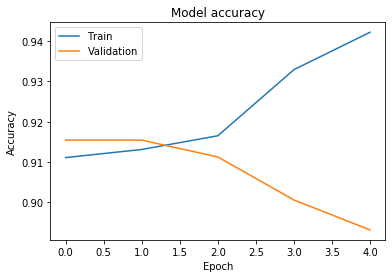

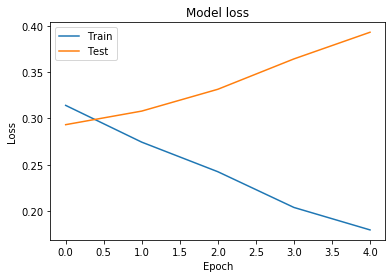

generating classfication report
Accuracy: 89.172862
  Classification Report:
              precision    recall  f1-score   support

          0       0.91      0.97      0.94      1966
          1       0.07      0.02      0.03       186

avg / total       0.84      0.89      0.86      2152
 

job finished
length of the data 15477
users 10760
cleanining the data



max_length 59
window_size 3
preparing the tokenizer
vocalb 10191
creating glove embeddign matrix
encoding the data
sequencing data



getting the output label
train-test split
(8608, 3, 59)
(2152, 3, 59)
(8608,)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3, 59)             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 3, 59, 100)        1019100   
_________________________________________________________________
reshape_6 (Reshape)          (None, 3, 5900)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 3, 200)            4800800   
_________________________________________________________________
flatten_6 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1202      
Total params: 5,821,102

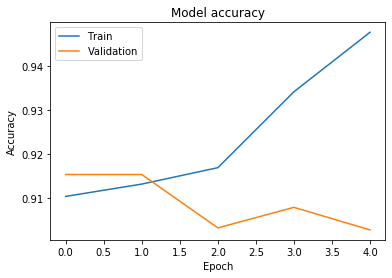

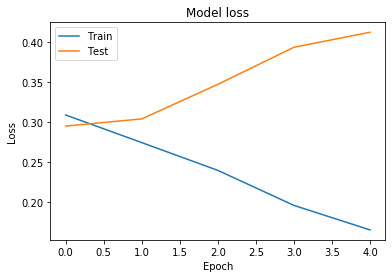

generating classfication report
Accuracy: 89.405204
  Classification Report:
              precision    recall  f1-score   support

          0       0.91      0.98      0.94      1966
          1       0.06      0.02      0.03       186

avg / total       0.84      0.89      0.86      2152
 

job finished
length of the data 18204
users 10760
cleanining the data



max_length 59
window_size 4
preparing the tokenizer
vocalb 11272
creating glove embeddign matrix
encoding the data
sequencing data



getting the output label
train-test split
(8608, 4, 59)
(2152, 4, 59)
(8608,)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 4, 59)             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 4, 59, 100)        1127200   
_________________________________________________________________
reshape_7 (Reshape)          (None, 4, 5900)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 4, 200)            4800800   
_________________________________________________________________
flatten_7 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 1602      
Total params: 5,929,602

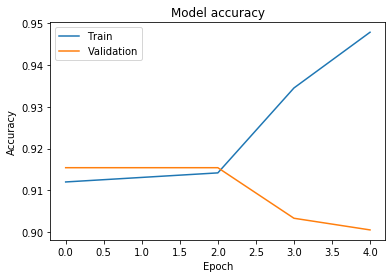

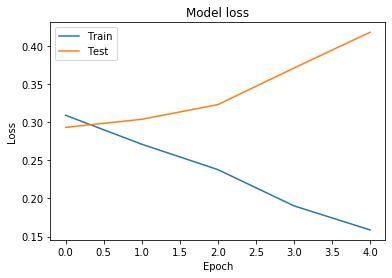

generating classfication report
Accuracy: 89.265799
  Classification Report:
              precision    recall  f1-score   support

          0       0.91      0.98      0.94      1966
          1       0.08      0.02      0.03       186

avg / total       0.84      0.89      0.86      2152
 

job finished
length of the data 20383
users 10760
cleanining the data



max_length 59
window_size 5
preparing the tokenizer
vocalb 12255
creating glove embeddign matrix
encoding the data
sequencing data



getting the output label
train-test split
(8608, 5, 59)
(2152, 5, 59)
(8608,)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 5, 59)             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 5, 59, 100)        1225500   
_________________________________________________________________
reshape_8 (Reshape)          (None, 5, 5900)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 5, 200)            4800800   
_________________________________________________________________
flatten_8 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 2002      
Total params: 6,028,302

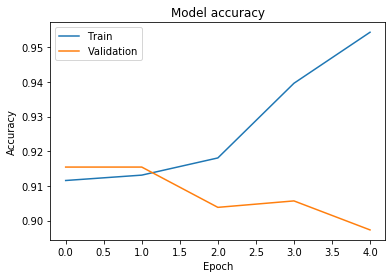

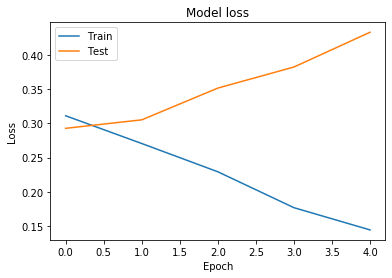

generating classfication report
Accuracy: 88.754647
  Classification Report:
              precision    recall  f1-score   support

          0       0.91      0.97      0.94      1966
          1       0.05      0.02      0.02       186

avg / total       0.84      0.89      0.86      2152
 

job finished


In [210]:
## run lstm models on all of the sequences
sequence_scores = []
sequence_models = []
for data in bucket_data:
    model,score = run_sequence_model(data,users_labelled,5,)
    sequence_scores.append(score)
    sequence_models.append(model)

In [241]:
## trying with the weights and then undersampling..
## run lstm models on all of the sequences
sequence_scores2 = []
sequence_models2 = []
for data in bucket_data:
    model,score = run_sequence_model(data,users_labelled,epoch=5,metrics=metrics,weights={0:1,1:20})
    sequence_scores2.append(score)
    sequence_models2.append(model)

length of the data 13087
users 10760
cleanining the data



max_length 59
window_size 2
preparing the tokenizer
vocalb 9180
creating glove embeddign matrix
encoding the data
sequencing data



getting the output label
train-test split
train-val split
X-train (6456, 2, 59)
X-test (2152, 2, 59)
X-val (2152, 2, 59)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 2, 59)             0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 2, 59, 100)        918000    
_________________________________________________________________
reshape_16 (Reshape)         (None, 2, 5900)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 2, 200)            4800800   
_________________________________________________________________
flatten_16 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)        


max_length 59
window_size 3
preparing the tokenizer
vocalb 10191
creating glove embeddign matrix
encoding the data
sequencing data



getting the output label
train-test split
train-val split
X-train (6456, 3, 59)
X-test (2152, 3, 59)
X-val (2152, 3, 59)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3, 59)             0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 3, 59, 100)        1019100   
_________________________________________________________________
reshape_17 (Reshape)         (None, 3, 5900)           0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 3, 200)            4800800   
_________________________________________________________________
flatten_17 (Flatten)         (None, 600)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)        


max_length 59
window_size 4
preparing the tokenizer
vocalb 11272
creating glove embeddign matrix
encoding the data
sequencing data



getting the output label
train-test split
train-val split
X-train (6456, 4, 59)
X-test (2152, 4, 59)
X-val (2152, 4, 59)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 4, 59)             0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 4, 59, 100)        1127200   
_________________________________________________________________
reshape_18 (Reshape)         (None, 4, 5900)           0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 4, 200)            4800800   
_________________________________________________________________
flatten_18 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)        


max_length 59
window_size 5
preparing the tokenizer
vocalb 12255
creating glove embeddign matrix
encoding the data
sequencing data



getting the output label
train-test split
train-val split
X-train (6456, 5, 59)
X-test (2152, 5, 59)
X-val (2152, 5, 59)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 5, 59)             0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 5, 59, 100)        1225500   
_________________________________________________________________
reshape_19 (Reshape)         (None, 5, 5900)           0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 5, 200)            4800800   
_________________________________________________________________
flatten_19 (Flatten)         (None, 1000)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)        

### random undersampling of the majority class

length of the data 13087
users 10760
cleanining the data



max_length 59
window_size 2
preparing the tokenizer
vocalb 9180
creating glove embeddign matrix
encoding the data
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 13087
users before 10760
after data 2410
after users 1858
getting the output label
sequencing data



train-test split
X-train (1114, 2, 59)
X-test (372, 2, 59)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 2, 59)             0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 2, 59, 100)        918000    
_________________________________________________________________
reshape_20 (Reshape)         (None, 2, 5900)           0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 2, 200)            4800800   
_________________________________________________________________
flatten_20 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 802       
Total params: 5,719,602
Trainable params: 

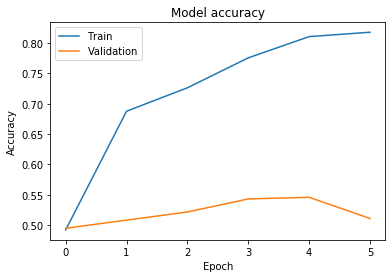

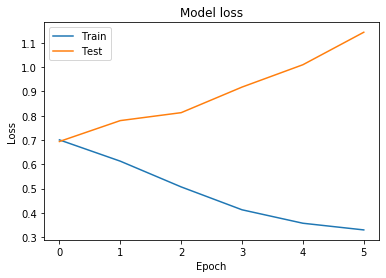

generating classfication report
Accuracy: 53.494624
  Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.44      0.48       186
           1       0.53      0.63      0.58       186

    accuracy                           0.53       372
   macro avg       0.54      0.53      0.53       372
weighted avg       0.54      0.53      0.53       372
 

job finished
length of the data 15477
users 10760
cleanining the data



max_length 59
window_size 3
preparing the tokenizer
vocalb 10191
creating glove embeddign matrix
encoding the data
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 15477
users before 10760
after data 3021
after users 1858
getting the output label
sequencing data



train-test split
X-train (1114, 3, 59)
X-test (372, 3, 59)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3, 59)             0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 3, 59, 100)        1019100   
_________________________________________________________________
reshape_21 (Reshape)         (None, 3, 5900)           0         
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 3, 200)            4800800   
_________________________________________________________________
flatten_21 (Flatten)         (None, 600)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 1202      
Total params: 5,821,102
Trainable params: 

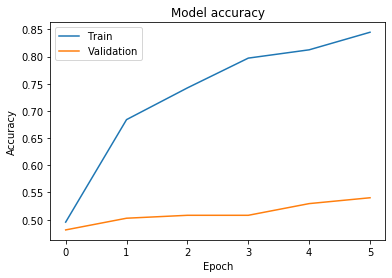

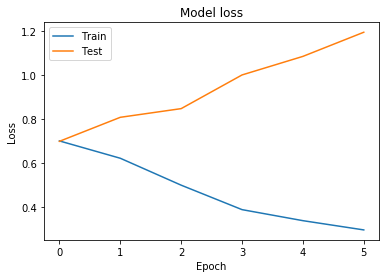

generating classfication report
Accuracy: 51.881720
  Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.53      0.53       186
           1       0.52      0.51      0.51       186

    accuracy                           0.52       372
   macro avg       0.52      0.52      0.52       372
weighted avg       0.52      0.52      0.52       372
 

job finished
length of the data 18204
users 10760
cleanining the data



max_length 59
window_size 4
preparing the tokenizer
vocalb 11272
creating glove embeddign matrix
encoding the data
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 18204
users before 10760
after data 3767
after users 1858
getting the output label
sequencing data



train-test split
X-train (1114, 4, 59)
X-test (372, 4, 59)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 4, 59)             0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 4, 59, 100)        1127200   
_________________________________________________________________
reshape_22 (Reshape)         (None, 4, 5900)           0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 4, 200)            4800800   
_________________________________________________________________
flatten_22 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 1602      
Total params: 5,929,602
Trainable params: 

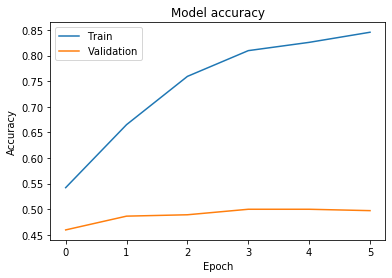

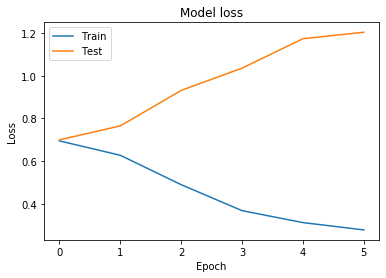

generating classfication report
Accuracy: 52.419355
  Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.47      0.50       186
           1       0.52      0.58      0.55       186

    accuracy                           0.52       372
   macro avg       0.52      0.52      0.52       372
weighted avg       0.52      0.52      0.52       372
 

job finished
length of the data 20383
users 10760
cleanining the data



max_length 59
window_size 5
preparing the tokenizer
vocalb 12255
creating glove embeddign matrix
encoding the data
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 20383
users before 10760
after data 4389
after users 1858
getting the output label
sequencing data



train-test split
X-train (1114, 5, 59)
X-test (372, 5, 59)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 5, 59)             0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 5, 59, 100)        1225500   
_________________________________________________________________
reshape_23 (Reshape)         (None, 5, 5900)           0         
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 5, 200)            4800800   
_________________________________________________________________
flatten_23 (Flatten)         (None, 1000)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 2002      
Total params: 6,028,302
Trainable params: 

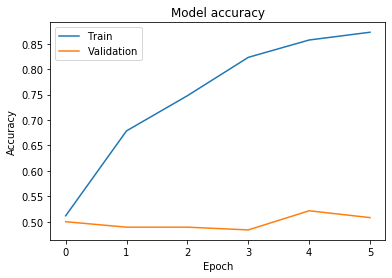

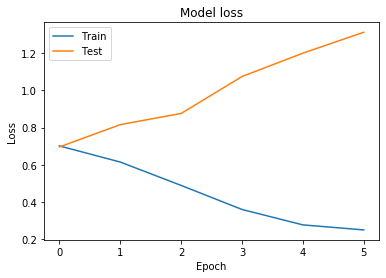

generating classfication report
Accuracy: 50.000000
  Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.40      0.45       186
           1       0.50      0.60      0.54       186

    accuracy                           0.50       372
   macro avg       0.50      0.50      0.50       372
weighted avg       0.50      0.50      0.50       372
 

job finished


In [223]:
## run lstm models on all of the sequences
sequence_scores3 = []
sequence_models3 = []
cleaned_data_list = []
for data in bucket_data:
    df,X,y,embedding_matrix,window,max_len,vocalb_size  = prepare_data_rnn(data,users_labelled)
    model,score = run_sequence_model(X,y,embedding_matrix,window,max_len,vocalb_size,epoch= 6,metrics=metrics)
    sequence_scores3.append(score)
    sequence_models3.append(model)
    cleaned_data_list.append(df)

In [229]:
dr = (cleaned_data_list)[3]
dr.loc[dr["tweetText"].apply(get_length) > 70]

,userID,tweetText,label
2,22363298,"i don't exactly know what a JUUL is but it's probably what ur man is putting around my neck ??????;crying in bed bc my cheating husband is brain dead and can't JUUL all over my tiddies anymore 😞; ok but is this what everyone talks about when they say JUUL? i don't know what it is; omg i just expanded the video and saw that u cited the fact that it's JUUL in the text...sorry to ask that redundant clarification before 😞;in the middle of working one of the single worst bar shifts i have ever worked last night, at one point i went to the backyard to hunt down someone who dipped on their tab and some random girl walks up and shoves a charger in my hand and says “CHARGE MY JUUL THXX” my goooooddddd; my ass is a temple i would not sully with a fucking JUUL",1
9,36601913,We will all get punished for juul i just don’t know how or when;I guess the bright side is the juul is very very clean now ... ya we washed our juul;Sometimes ... every so often ... you may find yourself blessed with a miracle when you don’t deserve one. Thing is ... we all need to remember that the universe may be cruel but is also serendipitously merciful. We found the juul.;My mom cleaned my apt but also slurped up all my juul juice.... trade offs,1
10,40020666,"I saw a dude charging a Juul using a Wii's USB port so that's how my Genesis is going;its weird mango chose his tag after that juul pod;I got drunk and bought a Juul last night so that's where I'm at in life;can I get juul to sponsor me for melee;shout out to this kid wearing a ""buchholz high school class of 2019"" shirt at this coffee shop ripping a juul as he counts quarters to buy a small coffee;Tbh I should just run up and steal this kid's juul. Like who is he gonna tattle to?;I know I talk a lot about the first juul rip of the day and how I like the crackle but goddamn it starts the day off right;i bought bootleg juul pods at a store next to my brunch and they're fuego;Just ripped the fattest Juul rip walking past an ABC7 camera so watch for that later",0
32,84390643,"I don’t do Juul. I have Jesus. ;The green light from the great gatsby was from a juul;disrespect is putting chapstick on and then hitting someone else’s juul right after;Yeah sex is cool and all, but have you ever ripped a Juul first thing in the morning?;ur mcm missed the birth of his first child because he was buying juul pods at the gas station across the street;When you rip the juul and hear mama comin down the hall...lmao ;Please bro lemme hit your juul bro please bro just one hit bro cmon bro lemme take a fat rip off your juul bro please bro I need your juul bro please lemme hit that juul bro please just one hit bro please bro I gottta have my juul fix bro please just one hit please bro juul me;what if the green light that gatsby saw across the water was daisy hitting her juul;Overheard in the quad, “yeah man, I almost forget I have a juul when I’m around her.” Ladies and gentlemen, chivalry is far from dead.;I was your juul but you ran out of pods - Rupi Kaur;saw this rando hitting his juul and the bond was made. bringing america together one cloud at a time ;WHY DID MY PARENTS LET ME ON THE INTERNET ALONE WHEN I WAS 8!!!!!! they broke me i didn't have to be like this.. i could be using a juul and listening to post malone with all the locals right now.... this life i live is just so messed up;Is 3 (three) juul hits a valid meal replacement yes or no;them: “you need to have more fruit” me: *gets mango juul pods instead of mint* “that should do it”;the green light from great gatsby was from a juul;The green light from Gatsby was just Daisy’s juul;this dude just hit a weed vape and a juul at the same time and called it a “silicon valley spliff” oh my god;*at thanksgiving dinner Mom: so your bf is a professional jeweler, that’s so interesting Daughter: no he’s a professional juuler Me: rips juul, blows out smoke to form the word “nice”;Today's list: ✅wake up rip juul ✅lip sync to Drake's new album a

## using svm approach

In [248]:
svm_scores = []
svm_models= []
rf_models= []
rf_scores = []
maj_scores = []
tfidf_list = []
for data in bucket_data:
    final = run_baslines(bucket_,users_labelled,)
    svm_model,svm_score = final["svm"]
    rf_model, rf_score = final["rf"]
    tf_idf = final["tf-idf"]
    maj_score = final["maj"]
    tfidf_list.append(tf_idf)
    svm_scores.append(svm_score)
    svm_models.append(svm_model)
    rf_scores.append(rf_score)
    rf_models.append(rf_model)
    maj_scores.append(maj_score)


preparing the tokenizer
downsampling
downsampled data length (1858, 10464)
train-test split
training the models
svm
[LibLinear]rf
predicting scores
  Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.67      0.63       186
           1       0.63      0.55      0.58       186

    accuracy                           0.61       372
   macro avg       0.61      0.61      0.61       372
weighted avg       0.61      0.61      0.61       372
 

  Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.79      0.68       186
           1       0.69      0.46      0.55       186

    accuracy                           0.62       372
   macro avg       0.64      0.62      0.61       372
weighted avg       0.64      0.62      0.61       372
 

  Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
      


preparing the tokenizer
downsampling
downsampled data length (1858, 10464)
train-test split
training the models
svm
[LibLinear]rf
predicting scores
  Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.67      0.63       186
           1       0.63      0.55      0.58       186

    accuracy                           0.61       372
   macro avg       0.61      0.61      0.61       372
weighted avg       0.61      0.61      0.61       372
 

  Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.79      0.68       186
           1       0.69      0.46      0.55       186

    accuracy                           0.62       372
   macro avg       0.64      0.62      0.61       372
weighted avg       0.64      0.62      0.61       372
 

  Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
      


preparing the tokenizer
downsampling
downsampled data length (1858, 10464)
train-test split
training the models
svm
[LibLinear]rf
predicting scores
  Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.67      0.63       186
           1       0.63      0.55      0.58       186

    accuracy                           0.61       372
   macro avg       0.61      0.61      0.61       372
weighted avg       0.61      0.61      0.61       372
 

  Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.79      0.68       186
           1       0.69      0.46      0.55       186

    accuracy                           0.62       372
   macro avg       0.64      0.62      0.61       372
weighted avg       0.64      0.62      0.61       372
 

  Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
      


preparing the tokenizer
downsampling
downsampled data length (1858, 10464)
train-test split
training the models
svm
[LibLinear]rf
predicting scores
  Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.67      0.63       186
           1       0.63      0.55      0.58       186

    accuracy                           0.61       372
   macro avg       0.61      0.61      0.61       372
weighted avg       0.61      0.61      0.61       372
 

  Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.79      0.68       186
           1       0.69      0.46      0.55       186

    accuracy                           0.62       372
   macro avg       0.64      0.62      0.61       372
weighted avg       0.64      0.62      0.61       372
 

  Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
      

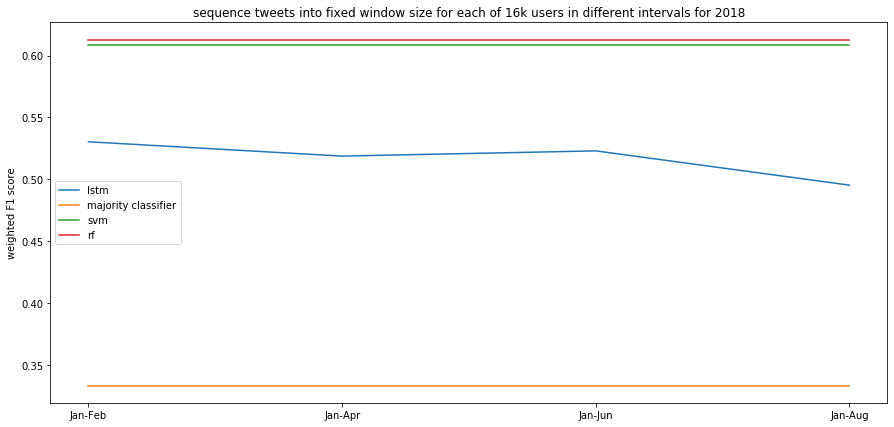

In [249]:
plt.figure(figsize=(15,7))
months = ["Jan-Feb","Jan-Apr","Jan-Jun","Jan-Aug"]
plt.plot(months,sequence_scores3,label="lstm")
plt.plot(months,(4*[maj_score]),label="majority classifier")
plt.plot(months,svm_scores,label="svm")
plt.plot(months,rf_scores,label="rf")
plt.title("sequence tweets into fixed window size for each of 16k users in different intervals for 2018")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

Jan-Feb


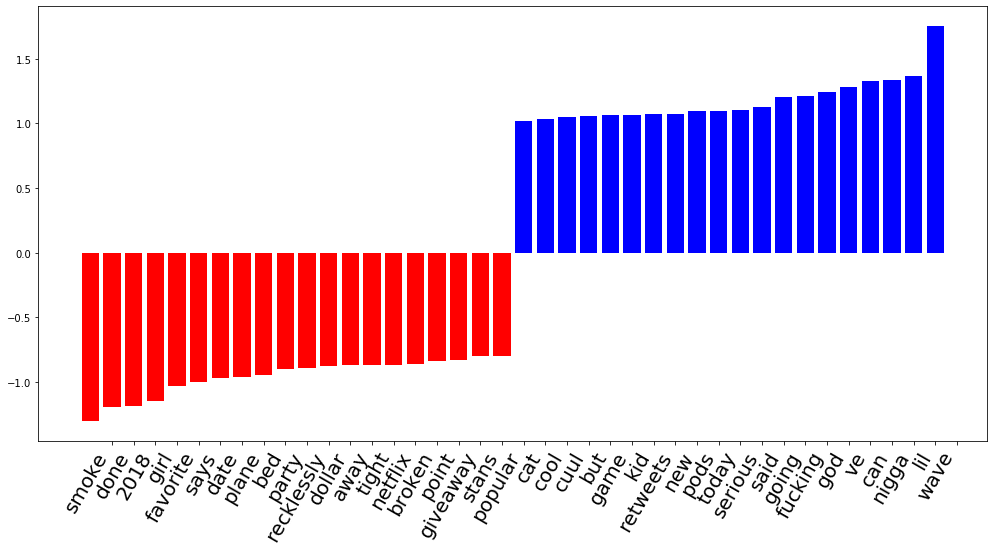

Jan-Apr


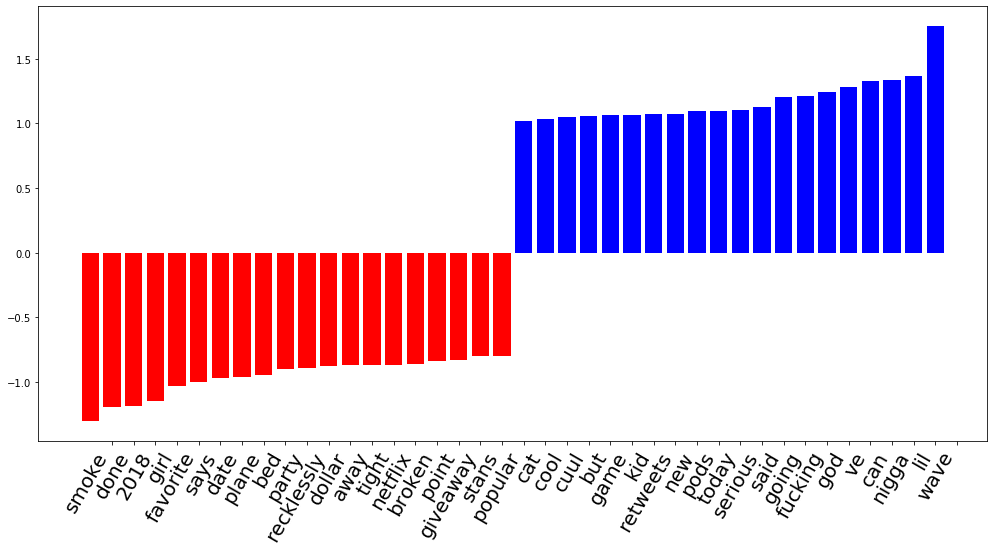

Jan-Jun


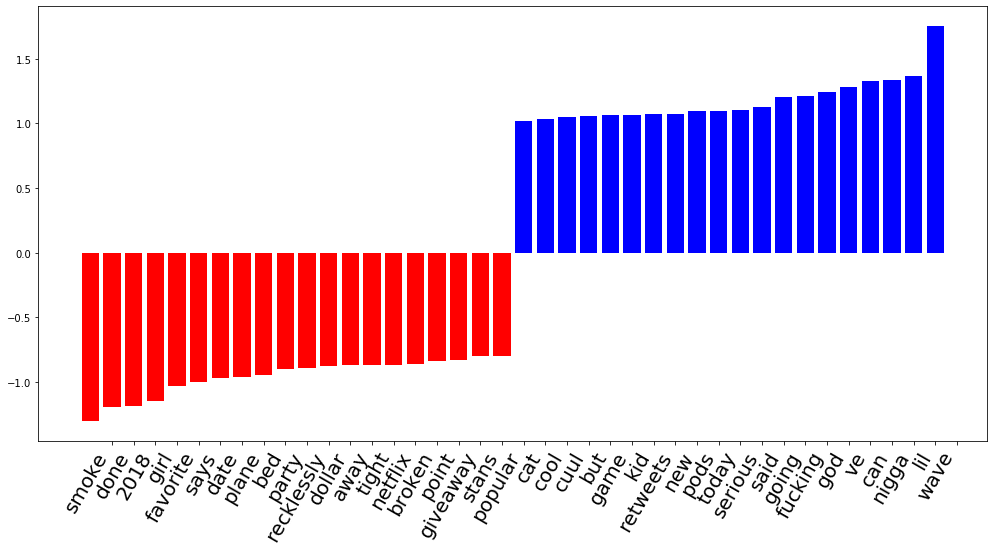

Jan-Aug


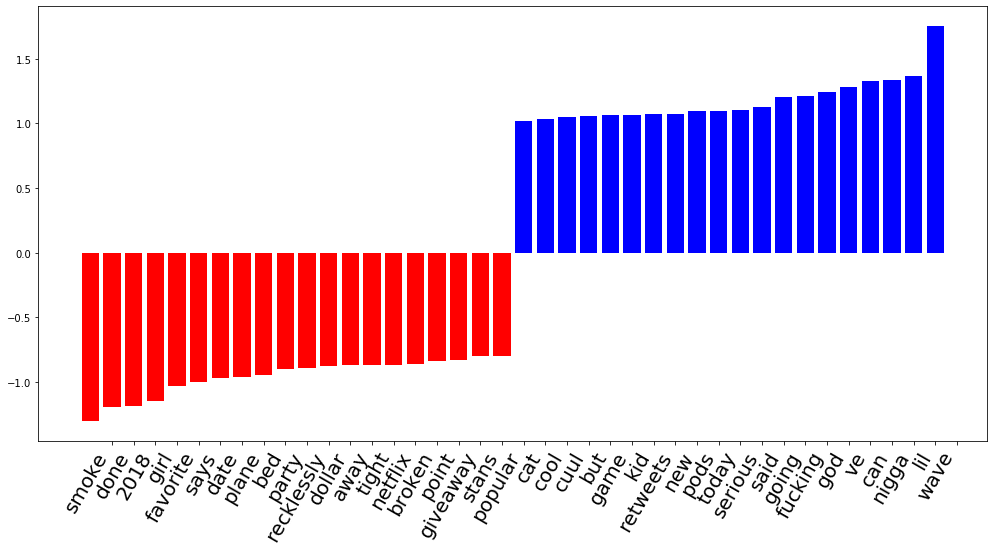

In [240]:
for svm,tf_idf,month in zip(svm_models,tfidf_list,months):
    print(month)
    plot_coeff(20,svm,tf_idf.get_feature_names())

In [777]:
## dump the scores
# with open(os.path.join(input_dir,"sequence_score.pkl"),"wb") as f:
#     pickle.dump(sequence_scores,f)

# with open(os.path.join(input_dir,"sequence_models.pkl"),"wb") as f:
#     pickle.dump(sequence_models,f)
    
# with open(os.path.join(input_dir,"svm_models.pkl"),"wb") as f:
#     pickle.dump(svm_models,f)

# with open(os.path.join(input_dir,"tf_idfs.pkl"),"wb") as f:
#     pickle.dump(tfidf_list,f)

In [526]:
sequence_scores = pickle.load(open(os.path.join(input_dir,"sequence_score.pkl"),"rb"))

### looking at sequence of scores in year based interval

In [44]:
## lok at the prediction accuracy fo classfier for different range intervals
## 2015 - 
## 2015 -16
## 2015 - 17
## juul_data and first_data
## lstm - sequence, without
## svm
## xgboost .. if it works

In [30]:
## input data :juul_data 
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## look at the weed first and juul_first tweet
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first_data = first_data.loc[first_data.userID.isin(regular_users)]  # reg users
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [31]:
## removing the rewteet text column completely
ids_ = juul_data.loc[juul_data['retweetText'].notnull()]["tweetId"]
juul_data.loc[juul_data.tweetId.isin(ids_),"tweetText"] = juul_data.loc[juul_data.tweetId.isin(ids_)]["retweetText"]
juul_data = juul_data.drop(["hashtags","retweetText"],axis=1)
len(juul_data) ## 1353987 (sanity check)

1353987

In [32]:
len(juul_data) ## 1353987
len(juul_data.userID.unique()) ## 673724  reg users

673724

In [63]:
bucket_list = []

In [64]:
## bucket 1
## 2014 -15 --
year = 2015
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year)  & (first_data.juul_first.dt.year > (year-1)))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2015
users that will change 97
total users 1049
length of data 2944


In [65]:
## bucket 2
## 2014 -16 --
year = 2016
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year)  & (first_data.juul_first.dt.year > (year-1)))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2016
users that will change 313
total users 1636
length of data 6475


In [66]:
## third bucket
## 2014 -17 --
year = 2017
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year)  & (first_data.juul_first.dt.year > (year-1)))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2017
users that will change 9525
total users 40236
length of data 111735


********************
year 2015
length of users 1049
length of the data 2944
users 1049
cleanining the data


max_length 16
window_size 8
preparing the tokenizer
vocalb 5648
creating glove embeddign matrix
encoding the data
total users before 1049
length of positive samples before 97
length of positive samples after 97
total users after 194
before data 2944
users before 1049
after data 727
after users 194
getting the output label
sequencing data


train-test split
X-train (116, 8, 16)
X-test (39, 8, 16)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 8, 16)             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 8, 16, 100)        564800    
_________________________________________________________________
reshape_7 (Reshape)          (None, 8, 1600)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 8, 200)            1360800   
_________________________________________________________________
flatten_7 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 3202      
Total params: 1,928,802
Trainable params: 1,9

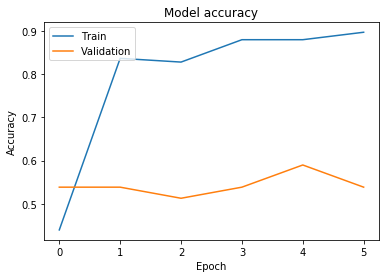

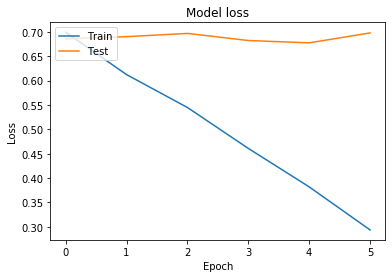

generating classfication report
Accuracy: 51.282052
  Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.55      0.54        20
           1       0.50      0.47      0.49        19

    accuracy                           0.51        39
   macro avg       0.51      0.51      0.51        39
weighted avg       0.51      0.51      0.51        39
 

job finished
********************
year 2016
length of users 1636
length of the data 6475
users 1636
cleanining the data


max_length 17
window_size 10
preparing the tokenizer
vocalb 7222
creating glove embeddign matrix
encoding the data
total users before 1636
length of positive samples before 259
length of positive samples after 259
total users after 518
before data 6475
users before 1636
after data 2386
after users 518
getting the output label
sequencing data


train-test split
X-train (310, 10, 17)
X-test (104, 10, 17)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 10, 17)            0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 10, 17, 100)       722200    
_________________________________________________________________
reshape_8 (Reshape)          (None, 10, 1700)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 10, 200)           1440800   
_________________________________________________________________
flatten_8 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 4002      
Total params: 2,167,002
Trainable params: 

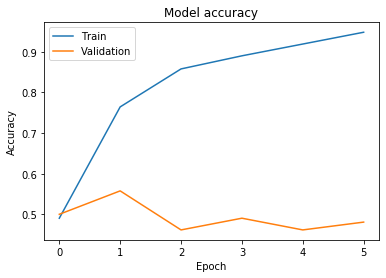

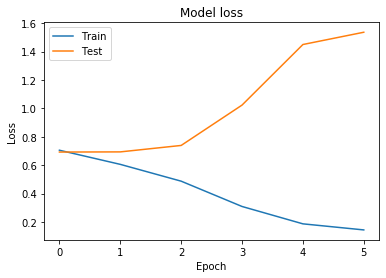

generating classfication report
Accuracy: 50.000000
  Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.56      0.53        52
           1       0.50      0.44      0.47        52

    accuracy                           0.50       104
   macro avg       0.50      0.50      0.50       104
weighted avg       0.50      0.50      0.50       104
 

job finished
********************
year 2017
length of users 40236
length of the data 111735
users 40236
cleanining the data


max_length 27
window_size 9
preparing the tokenizer
vocalb 20590
creating glove embeddign matrix
encoding the data
total users before 40236
length of positive samples before 9306
length of positive samples after 9306
total users after 18612
before data 111735
users before 40236
after data 62085
after users 18612
getting the output label
sequencing data


train-test split
X-train (11166, 9, 27)
X-test (3723, 9, 27)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 9, 27)             0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 9, 27, 100)        2059000   
_________________________________________________________________
reshape_9 (Reshape)          (None, 9, 2700)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 9, 200)            2240800   
_________________________________________________________________
flatten_9 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 3602      
Total params: 4,303,402
Trainable params:

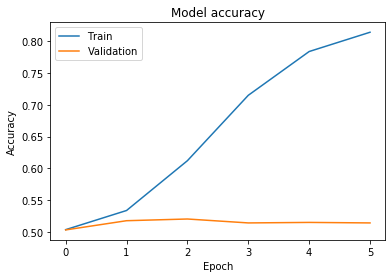

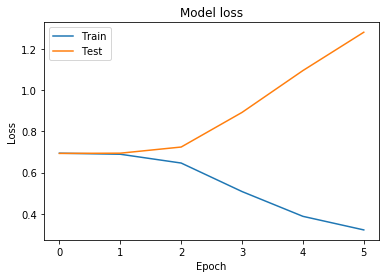

generating classfication report
Accuracy: 49.959710
  Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.50      1862
           1       0.50      0.49      0.49      1861

    accuracy                           0.50      3723
   macro avg       0.50      0.50      0.50      3723
weighted avg       0.50      0.50      0.50      3723
 

job finished


In [189]:
## will run lstm and other baseline models
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
sequence_scores = []
sequence_models = []
cleaned_data_list = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    df,X,y,embedding_matrix,window,max_len,vocalb_size  = prepare_data_rnn(data,users_lbl)
    model,score = run_sequence_model(X,y,embedding_matrix,window,max_len,vocalb_size,epoch= 6,metrics=metrics)
    sequence_scores.append(score)
    sequence_models.append(model)
    cleaned_data_list.append(df)

********************
year 2015
length of users 1049
length of the data 2944
users 1049
cleanining the data



max_length 16
total users before 1049
length of positive samples before 97
length of positive samples after 97
total users after 194
before data 2944
users before 1049
after data 727
after users 194
preparing the tokenizer
vocalb 2393
creating glove embeddign matrix
encoding the data
X (194, 16)
y (194,)
train-test split
X-train (116, 16)
X-test (39, 16)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 16, 100)           239300    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16, 200)           160800    
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0   

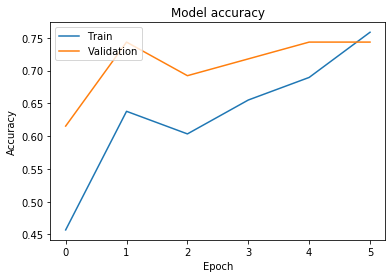

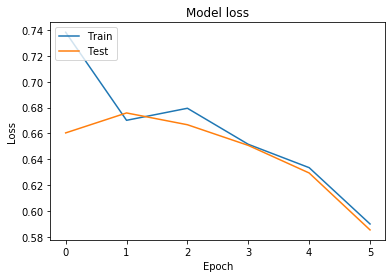

generating classfication report
Accuracy: 56.410257
  Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.75      0.64        20
           1       0.58      0.37      0.45        19

    accuracy                           0.56        39
   macro avg       0.57      0.56      0.54        39
weighted avg       0.57      0.56      0.55        39
 

job finished
********************
year 2016
length of users 1636
length of the data 6475
users 1636
cleanining the data



max_length 17
total users before 1636
length of positive samples before 259
length of positive samples after 259
total users after 518
before data 6475
users before 1636
after data 2386
after users 518
preparing the tokenizer
vocalb 3921
creating glove embeddign matrix
encoding the data
X (518, 17)
y (518,)
train-test split
X-train (310, 17)
X-test (104, 17)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 17)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 17, 100)           392100    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 17, 200)           160800    
_________________________________________________________________
flatten_3 (Flatten)          (None, 3400)              

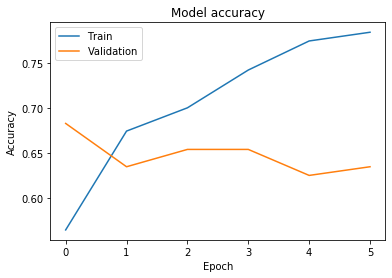

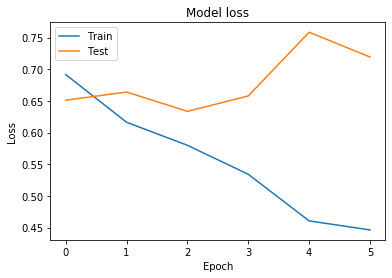

generating classfication report
Accuracy: 67.307692
  Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.62      0.65        52
           1       0.66      0.73      0.69        52

    accuracy                           0.67       104
   macro avg       0.68      0.67      0.67       104
weighted avg       0.68      0.67      0.67       104
 

job finished
********************
year 2017
length of users 40236
length of the data 111735
users 40236
cleanining the data



max_length 27
total users before 40236
length of positive samples before 9306
length of positive samples after 9306
total users after 18612
before data 111735
users before 40236
after data 62085
after users 18612
preparing the tokenizer
vocalb 15496
creating glove embeddign matrix
encoding the data
X (18612, 27)
y (18612,)
train-test split
X-train (11166, 27)
X-test (3723, 27)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 27)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 27, 100)           1549600   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 27, 200)           160800    
_________________________________________________________________
flatten_4 (Flatten)          (None, 

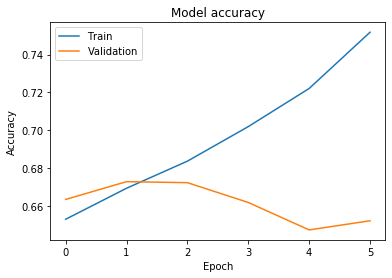

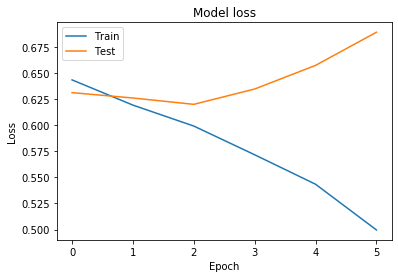

generating classfication report
Accuracy: 65.645984
  Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65      1862
           1       0.65      0.67      0.66      1861

    accuracy                           0.66      3723
   macro avg       0.66      0.66      0.66      3723
weighted avg       0.66      0.66      0.66      3723
 

job finished


In [90]:
## without sequencing
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
lstm_scores = []
lstm_models = []
cleaned_data_list = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    df,X,y,embedding_matrix,max_len,vocalb_size  = prepare_data_lstm(data,users_lbl)
    model,score = run_lstm_model(X,y,embedding_matrix,max_len,vocalb_size,dimension=100,epoch= 6,metrics=metrics)
    lstm_scores.append(score)
    lstm_models.append(model)
    cleaned_data_list.append(df)

#### basline models

In [44]:
svm_scores = []
svm_models= []
rf_models= []
rf_scores = []
maj_scores = []
tfidf_list = []
xgb_scores = []
xgb_models = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    final = run_baslines(data,users_lbl,)
    svm_model,svm_score = final["svm"]
    rf_model, rf_score = final["rf"]
    xgb_model,xgb_score = final["xg_boost"]
    tf_idf = final["tf-idf"]
    maj_score = final["maj"]
    tfidf_list.append(tf_idf)
    svm_scores.append(svm_score)
    svm_models.append(svm_model)
    rf_scores.append(rf_score)
    rf_models.append(rf_model)
    xgb_scores.append(xgb_score)
    xgb_models.append(xgb_model)
    maj_scores.append(maj_score)

********************
year 2015
length of users 1049



preparing the tokenizer
downsampling
downsampled data length (194, 5570)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.70      0.68        20
           1       0.67      0.63      0.65        19

    accuracy                           0.67        39
   macro avg       0.67      0.67      0.67        39
weighted avg       0.67      0.67      0.67        39
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.55      0.54        20
           1       0.50      0.47      0.49        19

    accuracy                           0.51        39
   macro avg       0.51      0.51      0.51        39
weighted avg       0.51      0.51      0.51        39
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.41     


preparing the tokenizer
downsampling
downsampled data length (518, 7099)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.60      0.61        52
           1       0.62      0.65      0.64        52

    accuracy                           0.62       104
   macro avg       0.63      0.62      0.62       104
weighted avg       0.63      0.62      0.62       104
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.83      0.70        52
           1       0.74      0.48      0.58        52

    accuracy                           0.65       104
   macro avg       0.67      0.65      0.64       104
weighted avg       0.67      0.65      0.64       104
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.63     


preparing the tokenizer
downsampling
downsampled data length (18612, 20250)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.71      0.67      1862
           1       0.67      0.57      0.62      1861

    accuracy                           0.64      3723
   macro avg       0.65      0.64      0.64      3723
weighted avg       0.65      0.64      0.64      3723
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.83      0.70      1862
           1       0.72      0.44      0.55      1861

    accuracy                           0.64      3723
   macro avg       0.66      0.64      0.62      3723
weighted avg       0.66      0.64      0.62      3723
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.64  

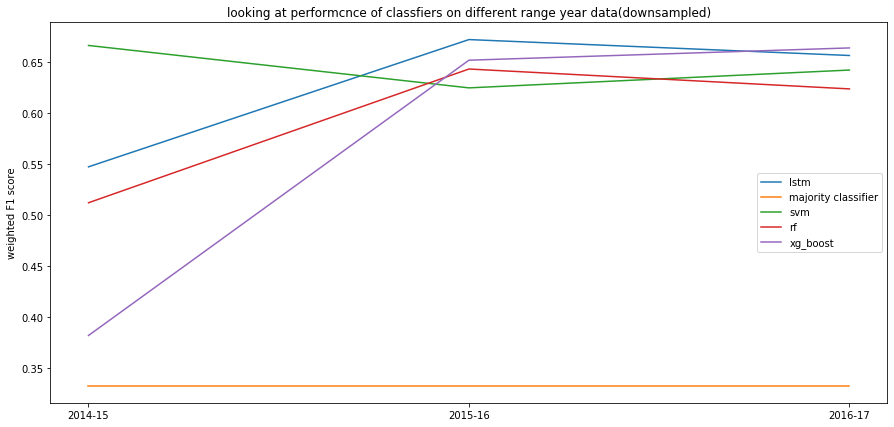

In [91]:
### plot for sequence scores
plt.figure(figsize=(15,7))
spans = ["2014-15","2015-16","2016-17"]
plt.plot(spans,lstm_scores,label="lstm")
plt.plot(spans,(3*[maj_score]),label="majority classifier")
plt.plot(spans,svm_scores,label="svm")
plt.plot(spans,rf_scores,label="rf")
plt.plot(spans,xgb_scores,label="xg_boost")
plt.title("looking at performcnce of classfiers on different range year data(downsampled)")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

2014-15


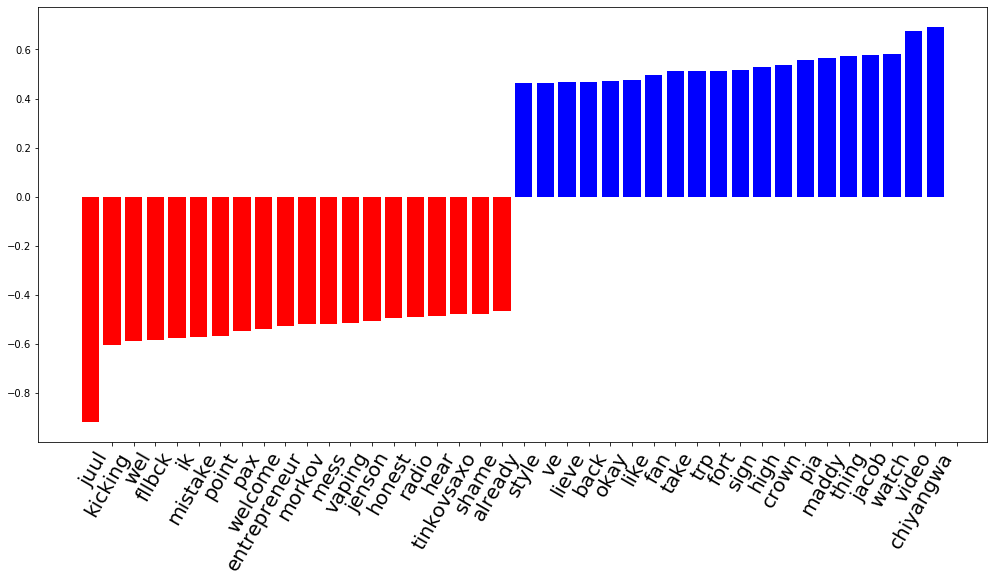

2015-16


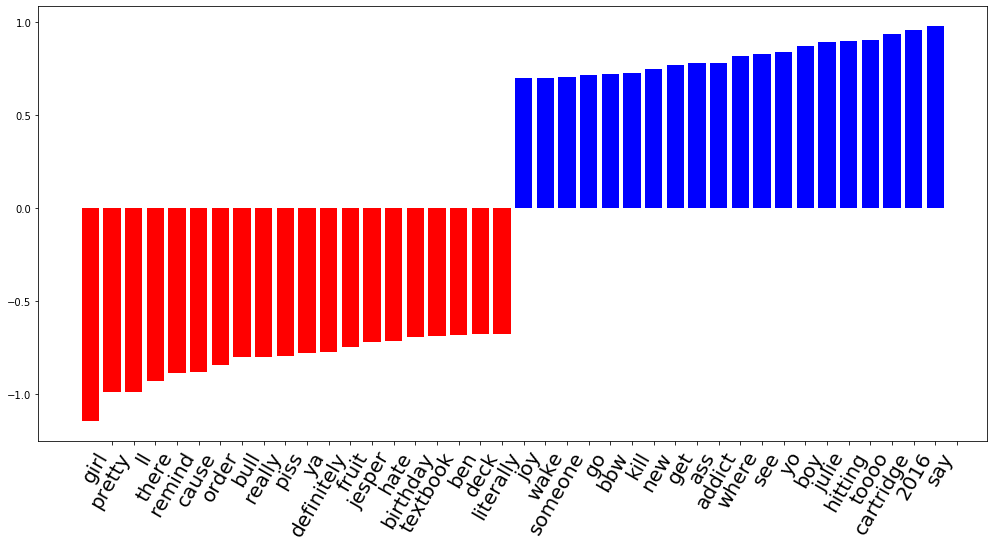

2016-17


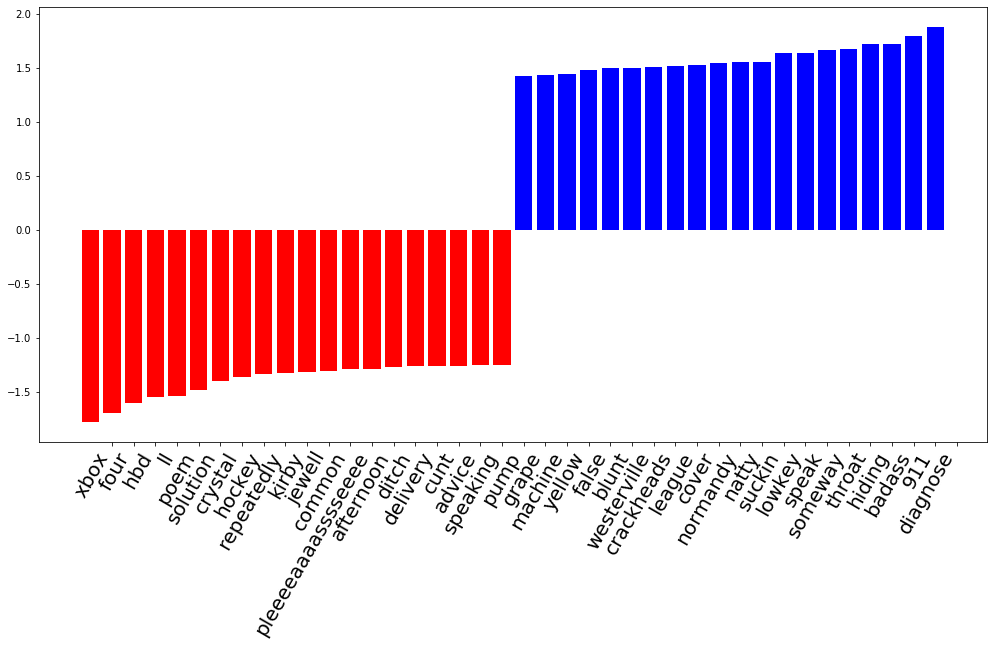

In [53]:
## most descriptive words by year
for svm,tf_idf,year in zip(svm_models,tfidf_list,spans):
    print(year)
    plot_coeff(20,svm,tf_idf.get_feature_names())

### looking at cumulative range of data

In [92]:
bucket_list = []
## bucket 1
## 2014 -15 --
year = 2015
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2015
users that will change 97
total users 1049
length of data 2944


In [93]:
## bucket 1
## 2014 -16 --
year = 2016
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2016
users that will change 313
total users 2642
length of data 9456


In [94]:
## bucket 1
## 2014 -17 --
year = 2017
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2017
users that will change 9525
total users 42784
length of data 120873


********************
year 2015
length of users 1049
length of the data 2944
users 1049
cleanining the data



max_length 16
total users before 1049
length of positive samples before 97
length of positive samples after 97
total users after 194
before data 2944
users before 1049
after data 727
after users 194
preparing the tokenizer
vocalb 2393
creating glove embeddign matrix
encoding the data
X (194, 16)
y (194,)
train-test split
X-train (116, 16)
X-test (39, 16)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 16)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 16, 100)           239300    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 16, 200)           160800    
_________________________________________________________________
flatten_5 (Flatten)          (None, 3200)              0   

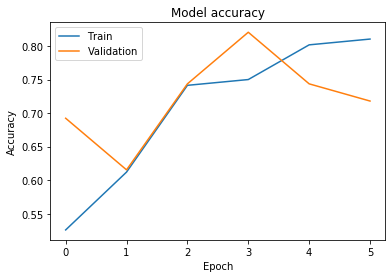

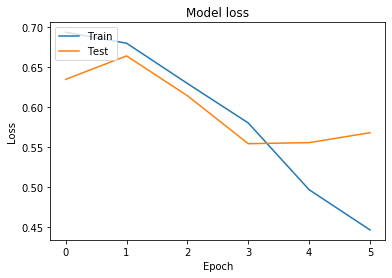

generating classfication report
Accuracy: 58.974359
  Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.75      0.65        20
           1       0.62      0.42      0.50        19

    accuracy                           0.59        39
   macro avg       0.60      0.59      0.58        39
weighted avg       0.60      0.59      0.58        39
 

job finished
********************
year 2016
length of users 2642
length of the data 9456
users 2642
cleanining the data



max_length 17
total users before 2642
length of positive samples before 313
length of positive samples after 313
total users after 626
before data 9456
users before 2642
after data 2878
after users 626
preparing the tokenizer
vocalb 4669
creating glove embeddign matrix
encoding the data
X (626, 17)
y (626,)
train-test split
X-train (375, 17)
X-test (126, 17)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 17)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 17, 100)           466900    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 17, 200)           160800    
_________________________________________________________________
flatten_6 (Flatten)          (None, 3400)              

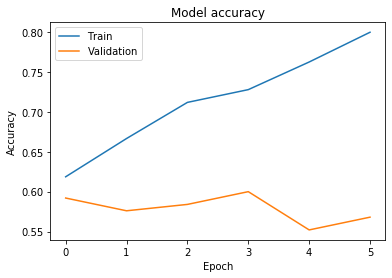

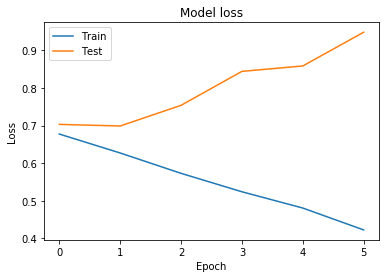

generating classfication report
Accuracy: 65.873016
  Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.73      0.68        63
           1       0.69      0.59      0.63        63

    accuracy                           0.66       126
   macro avg       0.66      0.66      0.66       126
weighted avg       0.66      0.66      0.66       126
 

job finished
********************
year 2017
length of users 42784
length of the data 120873
users 42784
cleanining the data



max_length 26
total users before 42784
length of positive samples before 9525
length of positive samples after 9525
total users after 19050
before data 120873
users before 42784
after data 63890
after users 19050
preparing the tokenizer
vocalb 16490
creating glove embeddign matrix
encoding the data
X (19050, 26)
y (19050,)
train-test split
X-train (11430, 26)
X-test (3810, 26)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 26)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 26, 100)           1649000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 26, 200)           160800    
_________________________________________________________________
flatten_7 (Flatten)          (None, 

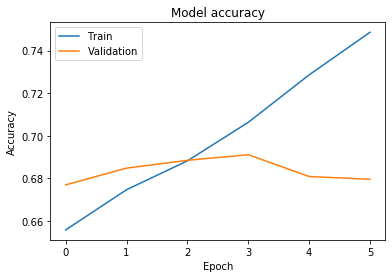

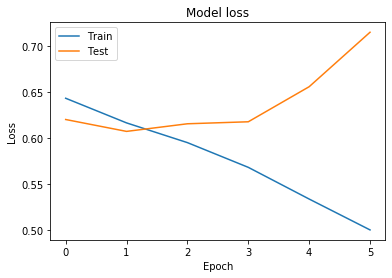

generating classfication report
Accuracy: 66.902887
  Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.71      0.68      1905
           1       0.68      0.63      0.66      1905

    accuracy                           0.67      3810
   macro avg       0.67      0.67      0.67      3810
weighted avg       0.67      0.67      0.67      3810
 

job finished


In [95]:
## RNN (LSTM)
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
lstm_scores = []
lstm_models = []
cleaned_data_list = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    df,X,y,embedding_matrix,max_len,vocalb_size  = prepare_data_lstm(data,users_lbl)
    model,score = run_lstm_model(X,y,embedding_matrix,max_len,vocalb_size,dimension=100,epoch= 6,metrics=metrics)
    lstm_scores.append(score)
    lstm_models.append(model)
    cleaned_data_list.append(df)

#### basline models

In [96]:
svm_scores = []
svm_models= []
rf_models= []
rf_scores = []
maj_scores = []
tfidf_list = []
xgb_scores = []
xgb_models = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    final = run_baslines(data,users_lbl,)
    svm_model,svm_score = final["svm"]
    rf_model, rf_score = final["rf"]
    xgb_model,xgb_score = final["xg_boost"]
    tf_idf = final["tf-idf"]
    maj_score = final["maj"]
    tfidf_list.append(tf_idf)
    svm_scores.append(svm_score)
    svm_models.append(svm_model)
    rf_scores.append(rf_score)
    rf_models.append(rf_model)
    xgb_scores.append(xgb_score)
    xgb_models.append(xgb_model)
    maj_scores.append(maj_score)

********************
year 2015
length of users 1049



preparing the tokenizer
downsampling
downsampled data length (194, 5572)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65        20
           1       0.63      0.63      0.63        19

    accuracy                           0.64        39
   macro avg       0.64      0.64      0.64        39
weighted avg       0.64      0.64      0.64        39
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50        20
           1       0.47      0.47      0.47        19

    accuracy                           0.49        39
   macro avg       0.49      0.49      0.49        39
weighted avg       0.49      0.49      0.49        39
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.40     


preparing the tokenizer
downsampling
downsampled data length (626, 9745)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.59      0.57        63
           1       0.57      0.54      0.55        63

    accuracy                           0.56       126
   macro avg       0.56      0.56      0.56       126
weighted avg       0.56      0.56      0.56       126
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.86      0.68        63
           1       0.70      0.33      0.45        63

    accuracy                           0.60       126
   macro avg       0.63      0.60      0.57       126
weighted avg       0.63      0.60      0.57       126
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.54     


preparing the tokenizer
downsampling
downsampled data length (19050, 23748)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.71      0.66      1905
           1       0.66      0.57      0.61      1905

    accuracy                           0.64      3810
   macro avg       0.64      0.64      0.64      3810
weighted avg       0.64      0.64      0.64      3810
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.77      0.68      1905
           1       0.68      0.50      0.57      1905

    accuracy                           0.63      3810
   macro avg       0.64      0.63      0.63      3810
weighted avg       0.64      0.63      0.63      3810
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.65  

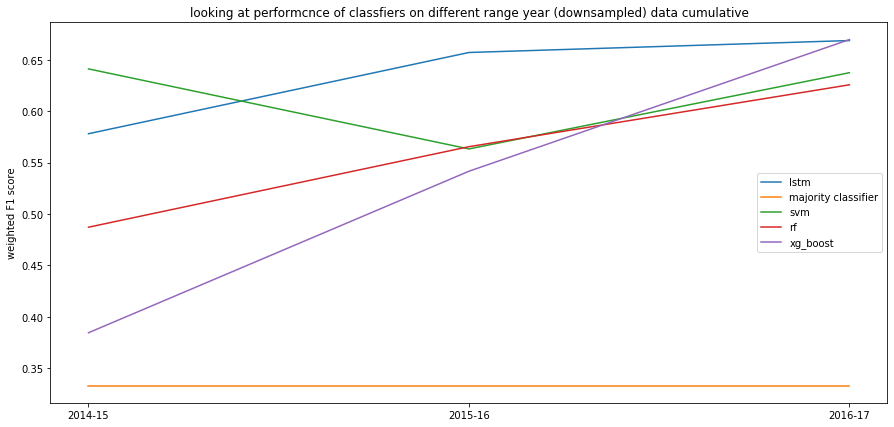

In [97]:
### plot with cumulative data
plt.figure(figsize=(15,7))
spans = ["2014-15","2014-16","2014-17"]
plt.plot(spans,lstm_scores,label="lstm")
plt.plot(spans,(3*[maj_score]),label="majority classifier")
plt.plot(spans,svm_scores,label="svm")
plt.plot(spans,rf_scores,label="rf")
plt.plot(spans,xgb_scores,label="xg_boost")
plt.title("looking at performcnce of classfiers on different range year (downsampled) data cumulative")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

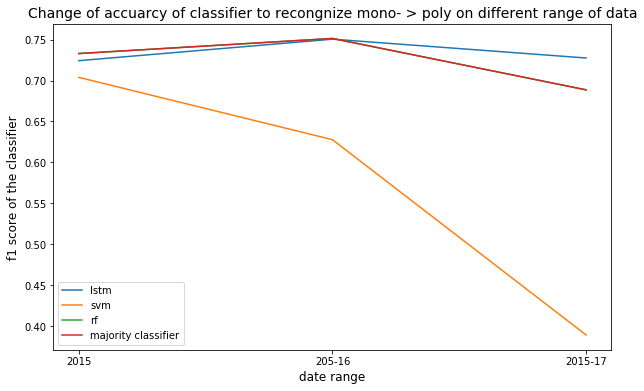

In [214]:
## without downsampling of data
fig, ax = plt.subplots(figsize = (10,6))
x_label = ["2015","205-16","2015-17"]
ax.plot(x_label,lstm_scores,label="lstm")
ax.plot(x_label,svm_scores,label="svm")
ax.plot(x_label,rf_scores,label="rf")
ax.plot(x_label,majority,label="majority classifier")
plt.title("Change of accuarcy of classifier to recongnize mono- > poly on different range of data",fontsize=14)
plt.xlabel("date range",fontsize=12)
plt.ylabel("f1 score of the classifier",fontsize=12)
plt.legend()
plt.show()